In [1]:
import sys
sys.path.append('../Codes/')
import numpy as np
import matplotlib.pyplot as plt
from Immuno_models import*
from Bio import Phylo
from io import StringIO
from matplotlib.lines import Line2D
from datetime import datetime, timedelta
import scipy.special as sc
import os.path
import pickle
from matplotlib import style
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from IPython.display import display, Math

def linear_func(x, a, b):
    return a + b*x
def quadratic_func(x, a, b, c):
    return np.log(a)+np.log(np.sqrt(-b)) + b*(x-c)**2

N_A = 6.02214076e23
k_BT = 1.380649e-23*293
style.use('seaborn-paper')
print(style.available)
%autosave 60

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


Autosaving every 60 seconds


## Generating Sequences

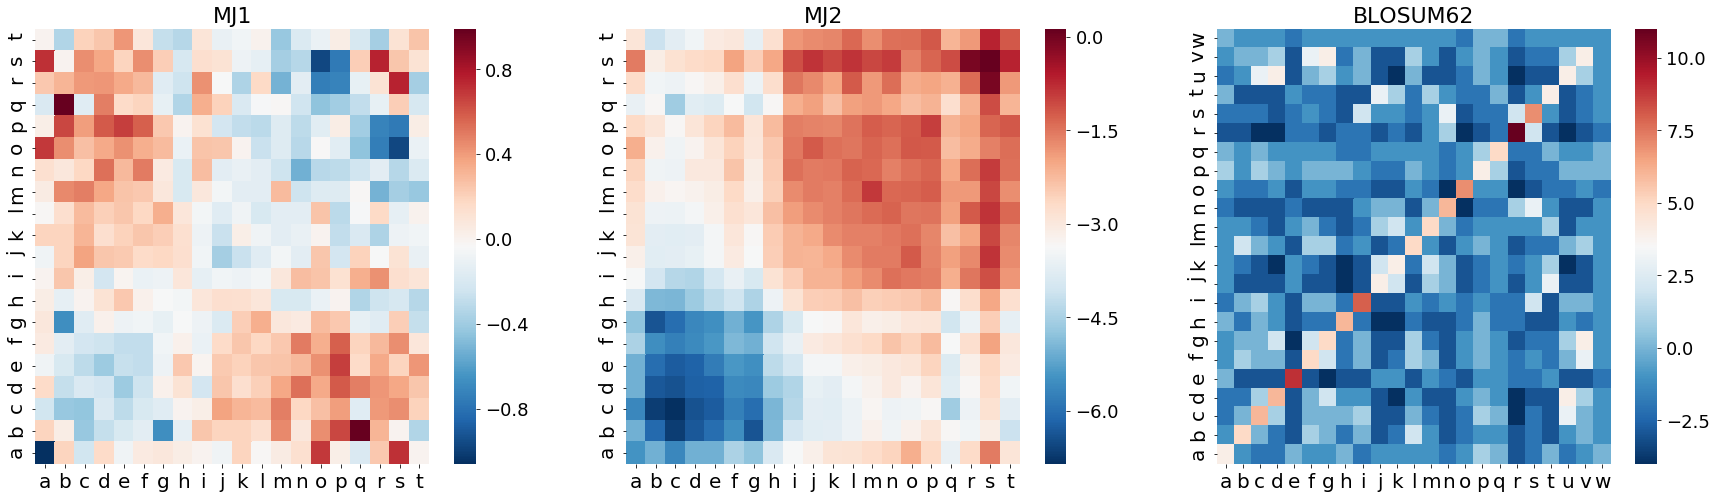

In [2]:
M1 = np.loadtxt('../Text_files/MJ.txt', skiprows= 1, usecols=range(1,21)).tolist()
M2 = (np.loadtxt('../Text_files/MJ2.txt', skiprows= 1, usecols=range(1,21))).tolist()
M3 = np.loadtxt('../Text_files/BLOSUM62.txt', skiprows= 1, max_rows = 23, usecols=range(1,24)).tolist()
Alphabet = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't']
Alphabet2 = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w']

fig, ax = plt.subplots(1,3,figsize=(30,8))

plot_energy_matrix(Energy_Matrix = M1, Alphabet = Alphabet, title = 'MJ1', ax = ax[0])
plot_energy_matrix(Energy_Matrix = M2, Alphabet = Alphabet, title = 'MJ2', ax = ax[1])
plot_energy_matrix(Energy_Matrix = M3, Alphabet = Alphabet2, title = 'BLOSUM62', ax = ax[2])

fig.savefig('../Figures/Energy_matrices.png')

In [3]:
%%time
n_seq = 500000

#Sequences = generate_Sequences(n_seq, Energy_Matrix = )
#pickle.dump( Sequences, open( "../Text_files/Sequences-n_seq-%d.pkl"%(n_seq), "wb" ) )

Sequences = pickle.load( open( "../Text_files/Sequences_MJ2-n_seq-%d.pkl"%(n_seq), "rb" ) )

#print_raw_file(Sequences, "../Text_files/file2.txt")
#generate_newick_format("../Text_files/file2.txt")


CPU times: user 3.34 s, sys: 309 ms, total: 3.65 s
Wall time: 3.49 s


In [4]:
Sequences[8000].master_sequence, Sequences[8000].sequence, Sequences[8000].hamming_distance, Sequences[8000].energy_parent, Sequences[8000].energy, Sequences[8000].delta_energy, Sequences[0].energy

('cgbccbbcc',
 'hgiecrkce',
 6,
 -29.600000000000005,
 -29.230000000000004,
 0.3700000000000001,
 -40.03)

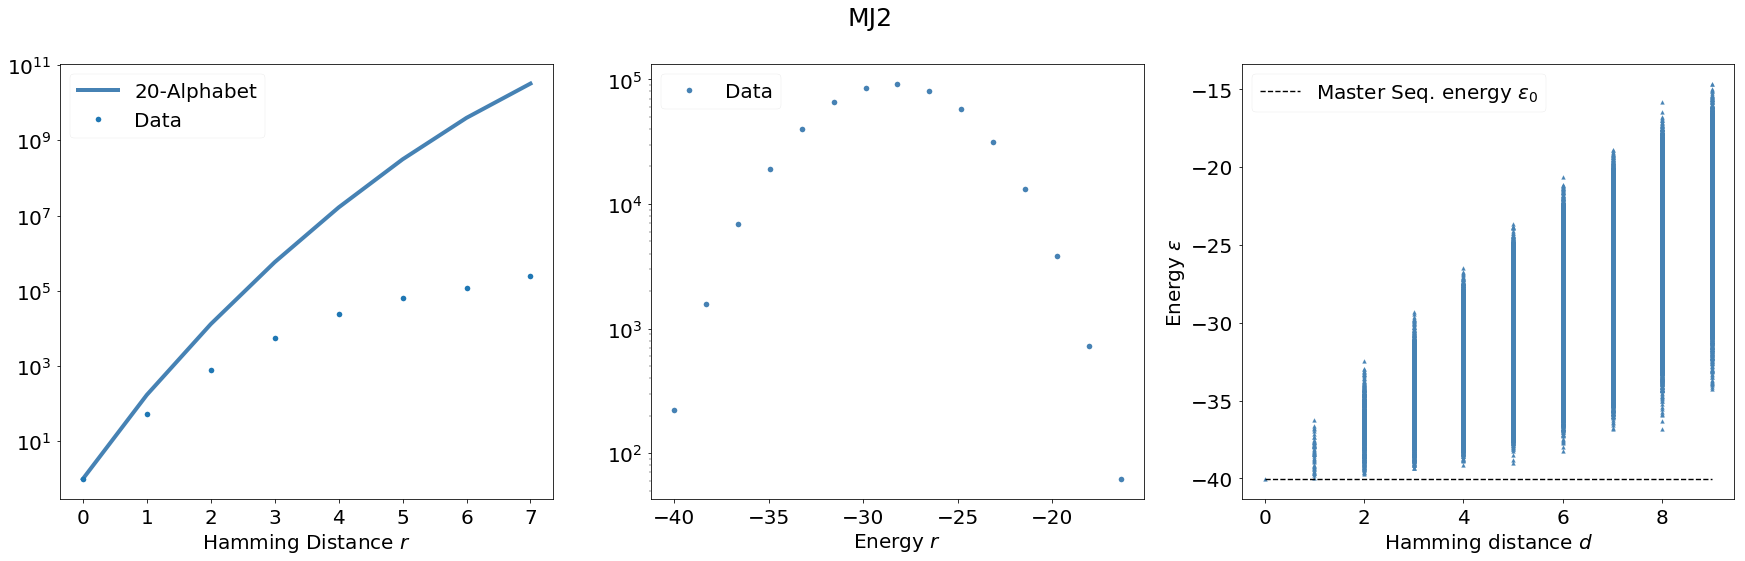

In [5]:
fig, ax = plt.subplots(1,3,figsize=(30,8))
fig.suptitle('MJ2', fontsize = 25)
distances = plot_histogram_hamming_distance(Sequences = Sequences, ax = ax[0])
energies, data_energies = plot_histogram_energy(Sequences = Sequences, bins = 15, ax = ax[1])
plot_scatter_hamming_distance_energy(distances = distances, energies = energies, ax = ax[2])

fig.savefig('../Figures/Sequences_MJ2-n_seq-%d.png'%(n_seq))


# Ensemble of systems

## Deterministic Model

### Distribution of linage sizes and activation rate

In [37]:
%%time
run_ensemble_deterministic_model(Sequences = Sequences, n_linages = 200, n_seq = 500000, nu = 1, beta = 1, T = 23, 
                                 master_Sequence_energy = 0, dt = 0.005, n_sim = 400, new = False)


0 ...
80 ...
160 ...
240 ...
320 ...
Ensemble size: 63251
CPU times: user 30min 43s, sys: 3.21 s, total: 30min 46s
Wall time: 30min 51s


integral: 426776.44387101685
240758.74585316647


<IPython.core.display.Math object>

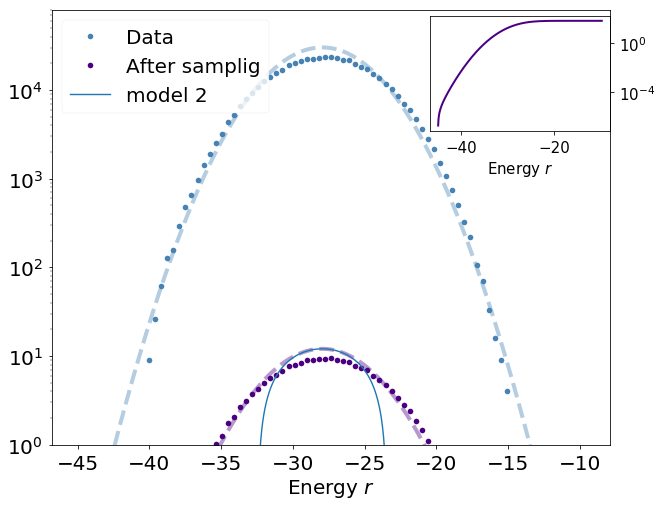

In [38]:
fig, ax = plt.subplots(1,1, figsize = (10, 8))
bins = 60
n_linages = 200
energies, data_energies = plot_histogram_energy(Sequences = Sequences, bins = bins, ax = ax)

#____________ fit and plot gaussian function
popt, pcov = curve_fit(quadratic_func, data_energies[1][0:-1], np.log(data_energies[0]) , p0 = (5e5/np.sqrt(np.pi), -0.04, -30))
print('integral:',popt[0]*np.pi)
r_array = np.linspace(np.min(energies)-5, np.max(energies)+5, 1000)
ax.plot(r_array, np.exp(quadratic_func(r_array, *popt)), linestyle = '--', linewidth = 4, color = 'steelblue', alpha = 0.4)
r_array2 = np.linspace(-80, 50, 10000)
print(np.cumsum(np.exp(quadratic_func(r_array2, *popt))*(130)/10000)[-1])

#____________ Create sub_energies (uncomment when kernel is restarted)
#sub_energies = np.array([])
#for i in range(5000):
#    Sub_Sequences = np.random.choice(Sequences, n_linages)
#    sub_energies = np.append(sub_energies,np.array([i.energy for i in Sub_Sequences]))

#____________ Plot histogram of sub_energies
data_energies = np.histogram(sub_energies, bins=bins, density = False)
ax.plot(data_energies[1][0:-1], data_energies[0]/(5000), linewidth = 4, color = 'indigo', label = 'After samplig', linestyle = '', marker = 'o')
ax.plot(r_array, (2e2/5e5)*np.exp(quadratic_func(r_array, *popt)), linestyle = '--', linewidth = 4, color = 'indigo', alpha = 0.4)
ax.plot(r_array, (2e2/5e5)*popt[0]*np.sqrt(-popt[1])*(1+popt[1]*(r_array-popt[2])**2), label = 'model 2')


ax.set_ylim(1,8e4)
handles, labels = ax.get_legend_handles_labels()
ax.legend(np.concatenate(([],handles)),np.concatenate(([],labels)), loc = 2, fontsize = 20)

#____________ Create inset with the integral of the gaussian function  
left, bottom, width, height = [0.65, 0.67, 0.25, 0.2]
ax2 = fig.add_axes([left, bottom, width, height])
ax2.plot(r_array, np.cumsum((2e2/5e5)*np.exp(quadratic_func(r_array, *popt))*(np.max(energies)-np.min(energies))/1000), linewidth = 2, color = 'indigo')
ax2.set_xlabel(r'Energy $r$', fontsize = 15)
ax2.set_ylabel(r'', fontsize = 15)
ax2.tick_params(labelsize = 15)
ax2.yaxis.tick_right()
ax2.set_yscale('log')
#___________________________________________ 
display(Math(r'y = %.3f e^{%.3f(\epsilon%.1f)^2}'%((popt[0]), popt[1], popt[2])))
fig.savefig('../Figures/Sequences.png')

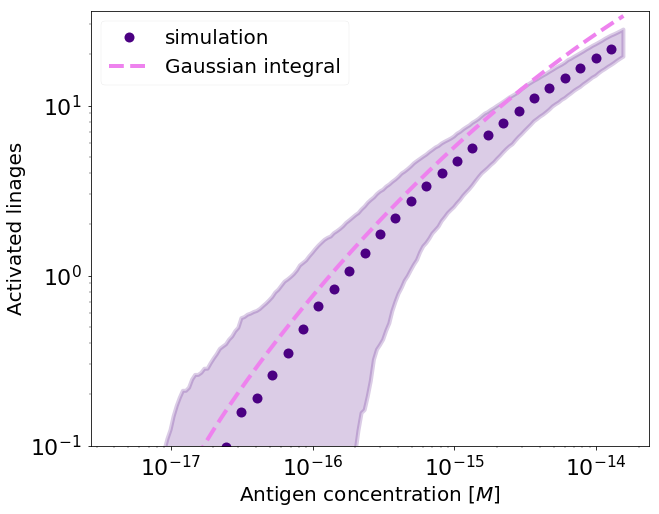

In [39]:
fig, ax = plt.subplots(1, 1, figsize = (10,8))
T=23
dt=0.005

#____________ Read and plot the activation of linages as function of antigen concetration
t_new = np.linspace(0, T, int(T/dt))
activation_time_series = pickle.load( open( "../Text_files/ensemble_deterministic_model_activation_time_series.pkl", "rb" ) )
activation_time_series_var = pickle.load( open( "../Text_files/ensemble_deterministic_model_activation_time_series_var.pkl", "rb" ) )
ax.plot(np.exp(t_new[1:][::50][np.where(activation_time_series[1:][::50]!=0)])/N_A, activation_time_series[1:][::50][np.where(activation_time_series[1:][::50]!=0)], linestyle = '', marker = '.', ms = 20, linewidth = 4, color = 'indigo', label = 'simulation')
ax.fill_between(np.exp(t_new[1:][::10][np.where(activation_time_series[1:][::10]!=0)])/N_A , activation_time_series[1:][::10][np.where(activation_time_series[1:][::10]!=0)] - np.sqrt(activation_time_series_var[1:][::10][np.where(activation_time_series[1:][::10]!=0)]), activation_time_series[1:][::10][np.where(activation_time_series[1:][::10]!=0)] + np.sqrt(activation_time_series_var[1:][::10][np.where(activation_time_series[1:][::10]!=0)]), linewidth = 4, color = 'indigo', alpha = 0.2)

#____________ Plot the gaussian integral
r_array = np.linspace(np.min(energies), np.max(np.log(np.exp(t_new[1:][::10][np.where(activation_time_series[1:][::10]!=0)])/N_A)), 5000)
ax.plot(np.exp(r_array), np.cumsum((2e2/5e5)*np.exp(quadratic_func(r_array, *popt))*(np.max(energies)-np.min(energies))/5000), linestyle = '--', ms = 20, linewidth = 4, color = 'violet', label = 'Gaussian integral')

ax.set_xlabel(r'Antigen concentration $[M]$', fontsize = 20)
ax.set_ylabel(r'Activated linages', fontsize = 20)
ax.tick_params(labelsize = 22)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(0.1, max(activation_time_series[1:]*1.5))
ax.legend(loc = 0, fontsize = 20)
#_______________________________________________________________________________________________________________

fig.savefig('../Figures/Activation_rate.png')


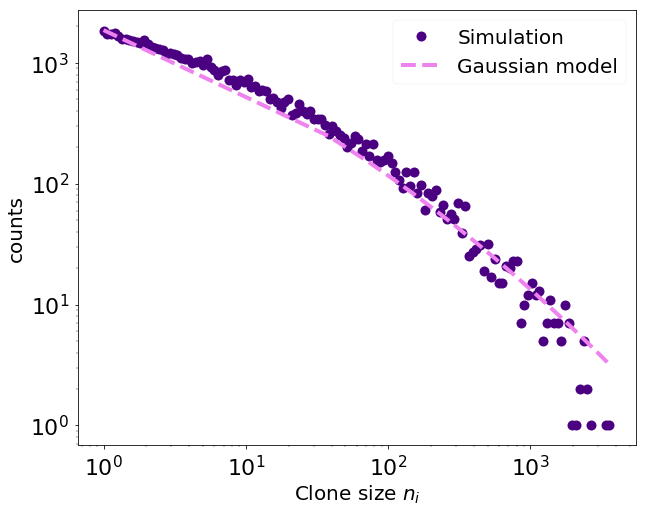

In [43]:
fig, ax = plt.subplots(1, 1, figsize = (10,8))

#____________ Read and plot the distribution of clone sizes
activated_linages_size = pickle.load( open( "../Text_files/ensemble_deterministic_model_linage_sizes.pkl", "rb" ) )
data_activated_linages_log = np.histogram(activated_linages_size, bins = np.logspace(0,np.log10(np.max(activated_linages_size)*2),150), density = False)
#data_activated_linages_lin = np.histogram(activated_linages_size, bins = np.linspace(1,np.max(activated_linages_size),20), density = False)
#Distribution
ax.plot(data_activated_linages_log[1][:-1][np.where(data_activated_linages_log[0]!=0)], data_activated_linages_log[0][np.where(data_activated_linages_log[0]!=0)], marker = '.', ms = 20, linestyle = '', linewidth = 3, color = 'indigo', label = 'Simulation')
#ax.plot(data_activated_linages_lin[1][:-1][np.where(data_activated_linages_lin[0]!=0)], data_activated_linages_lin[0][np.where(data_activated_linages_lin[0]!=0)], marker = '.', ms = 20, linestyle = '-', linewidth = 3, color = 'tab:brown', label = 'linear')

#____________ Plot the gaussian integral
n_array = np.linspace(1,np.max(activated_linages_size), 100)
ax.plot(n_array, ((len(activated_linages_size)/2e2)*(2e2/5e5)*np.exp(quadratic_func(np.log((np.exp(T)/N_A)/(n_array)), *popt))), linestyle = '--', ms = 20, linewidth = 4, color = 'violet', label = 'Gaussian model')

ax.set_xlabel(r'Clone size $n_i$', fontsize = 20)
ax.set_ylabel(r'counts', fontsize = 20)
ax.tick_params(labelsize = 22)
ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_xlim(.9,1000)
ax.legend(loc = 0, fontsize = 20)
fig.savefig('../Figures/Linage_size_distribution.png')
#_______________________________________________________________________________________________________________

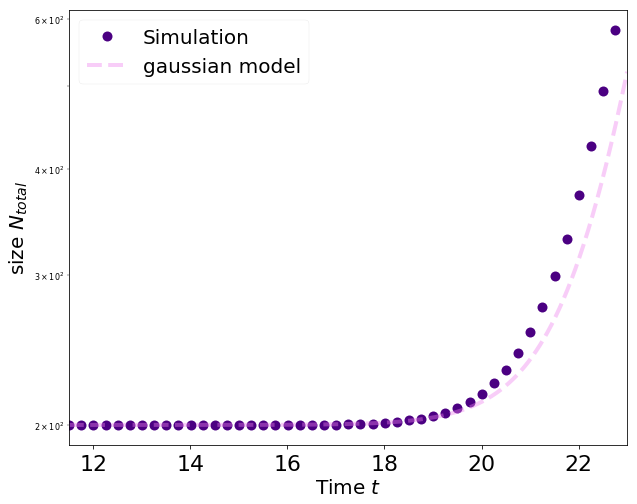

In [44]:
fig, ax = plt.subplots(1, 1, figsize = (10,8))

#____________ Read and plot the distribution of clone sizes
N_total_sim = pickle.load( open( "../Text_files/ensemble_deterministic_model_N_total.pkl", "rb" ) )

#Total linage size
ax.plot(t_new[::50], N_total_sim[::50], marker = '.', ms = 20, linestyle = '', linewidth = 3, color = 'indigo', label = 'Simulation')

#____________ Plot the gaussian integral
N_total = np.array([np.cumsum(np.exp(t-np.linspace(0,t, 100))*(2e2/5e5)*np.exp(quadratic_func(np.log(np.exp(np.linspace(0,t, 100))/N_A), *popt))*(t/100))[-1] + 200 - np.cumsum((2e2/5e5)*np.exp(quadratic_func(np.log(np.exp(np.linspace(0,t, 100))/N_A), *popt))*(t/100))[-1] for t in t_new])
ax.plot(t_new, N_total, linestyle = '--', linewidth = 4, color = 'violet', alpha = 0.4, label = 'gaussian model')

ax.set_xlabel(r'Time $t$', fontsize = 20)
ax.set_ylabel(r'size $N_{total}$', fontsize = 20)
ax.tick_params(labelsize = 22)
#ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(T/2,T)
ax.legend(loc = 0, fontsize = 20)
fig.savefig('../Figures/N_total_ensemble.png')
#_______________________________________________________________________________________________________________

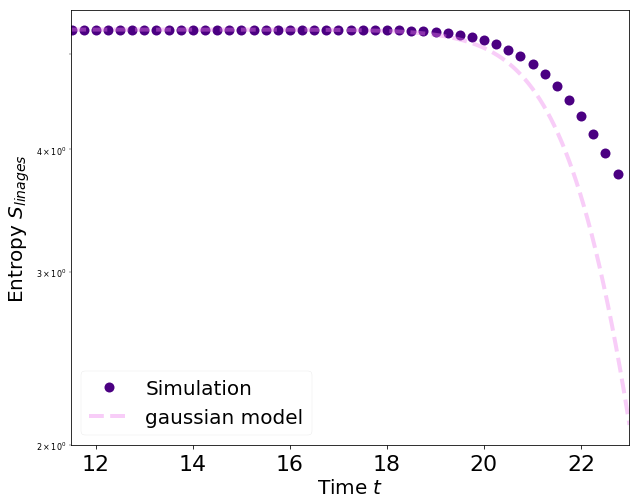

In [42]:
fig, ax = plt.subplots(1, 1, figsize = (10,8))

#____________ Read and plot the distribution of clone sizes
entropy = pickle.load( open( "../Text_files/ensemble_deterministic_model_entropy.pkl", "rb" ) )

#Total linage size
ax.plot(t_new[::50], entropy[::50], marker = '.', ms = 20, linestyle = '', linewidth = 3, color = 'indigo', label = 'Simulation')

#____________ Plot the gaussian integral
N_total = np.array([np.cumsum(np.exp(t-np.linspace(0,t, 100))*(2e2/5e5)*np.exp(quadratic_func(np.log(np.exp(np.linspace(0,t, 100))/N_A), *popt))*(t/100))[-1] + 200 - np.cumsum((2e2/5e5)*np.exp(quadratic_func(np.log(np.exp(np.linspace(0,t, 100))/N_A), *popt))*(t/100))[-1] for t in t_new])
N_alpha_log_N_alpha = np.array([np.cumsum((np.exp(t-np.linspace(0,t, 100))*(t-np.linspace(0,t, 100))*(2e2/5e5)*np.exp(quadratic_func(np.log(np.exp(np.linspace(0,t, 100))/N_A), *popt)))*(t/100))[-1] for t in t_new])

ax.plot(t_new, (-1/N_total)*(N_alpha_log_N_alpha) + np.log(N_total), linestyle = '--', linewidth = 4, color = 'violet', alpha = 0.4, label = 'gaussian model')

ax.set_xlabel(r'Time $t$', fontsize = 20)
ax.set_ylabel(r'Entropy $S_{linages}$', fontsize = 20)
ax.tick_params(labelsize = 22)
#ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(T/2,T)
ax.legend(loc = 0, fontsize = 20)
fig.savefig('../Figures/Entropy_ensemble.png')
#_______________________________________________________________________________________________________________

## Stochastic Model

### Distribution of linage sizes

In [4]:
%%time
run_ensemble_linage_size_distribution(Sequences = Sequences, n_linages = 200, n_seq = 400000, nu = 0.4, beta = 1,
                                     T = 5, master_Sequence_energy = 14, n_sim = 5, new = False)


0 ...
1 ...
2 ...
3 ...
4 ...
Ensemble size: 72270


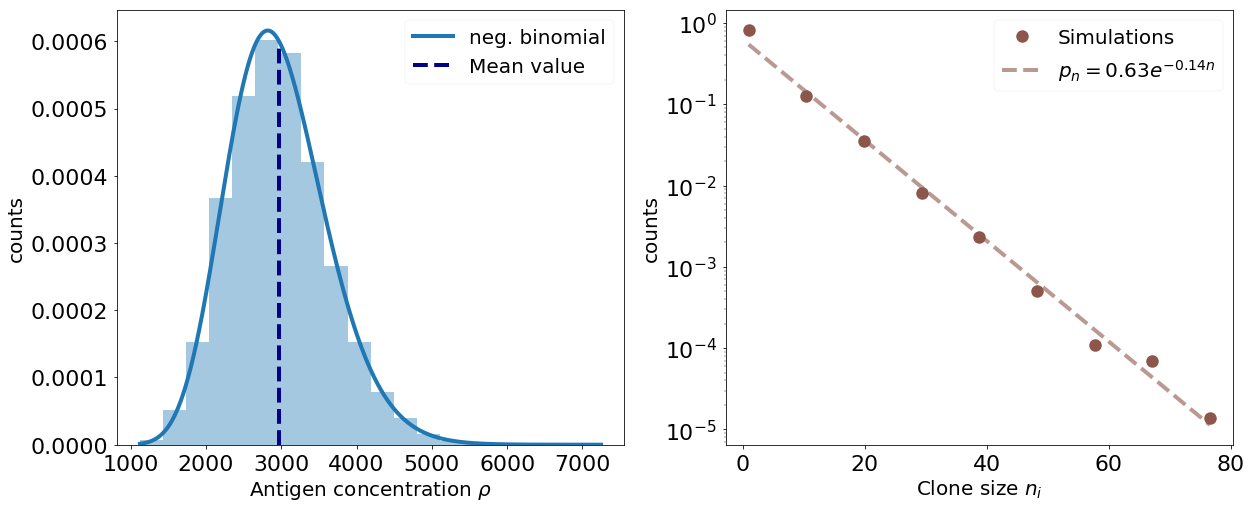

In [308]:
fig, ax = plt.subplots(1, 2, figsize = (20,8))

#_______________________________________________________________________________________________________________

final_antigen_concentration = pickle.load( open( "../Text_files/final_antigen_concentration.pkl", "rb" ) )

x = np.array(range(int(min(final_antigen_concentration)) , int(max(final_antigen_concentration))))
p = np.exp(-1*5)
n_array = np.array(range(1,80))

ax[0].hist(final_antigen_concentration, bins = 20, density = True, alpha = 0.4)
ax[0].plot(x, sc.comb(x-1, x-20)*p**(20)*(1-p)**(x-20), color = 'tab:blue', linewidth = 4, ms=8, label='neg. binomial')
ax[0].vlines(20*np.exp(5), 0, sc.comb(20*np.exp(5)-1, 20*np.exp(5)-20)*p**(20)*(1-p)**(20*np.exp(5)-20), linestyle = 'dashed', linewidth = 4, color = 'darkblue', label = 'Mean value')
ax[0].set_xlabel(r'Antigen concentration $\rho$', fontsize = 20)
ax[0].set_ylabel(r'counts', fontsize = 20)
ax[0].tick_params(labelsize = 22)
ax[0].legend(loc = 0, fontsize = 20)
#_______________________________________________________________________________________________________________

activated_linages_size_t = pickle.load( open( "../Text_files/activated_linages_size_t.pkl", "rb" ) )

#data_activated_linages2 = np.histogram(activated_linages_size_t, bins = np.logspace(1,np.log10(np.max(activated_linages_size_t)),10))
data_activated_linages2 = np.histogram(activated_linages_size_t, bins = np.linspace(1,np.max(activated_linages_size_t),10))

#Cumulative
#ax[1].plot(data_activated_linages[1][:-1], 1-np.cumsum(data_activated_linages[0])/np.sum(data_activated_linages[0]), marker = '.', ms = 20, linestyle = '', linewidth = 4, color = 'tab:red')
#ax[1].plot(data_activated_linages[1][:-1], (data_activated_linages[0][0]/np.sum(data_activated_linages[0]))*(data_activated_linages[1][:-1])**(-1), linestyle = '--', color = 'tab:red', label = r'$p\sim n_i^{-1}$')

#Distribution
#ax[1].plot(data_activated_linages[1][:-1], data_activated_linages[0]/np.sum(data_activated_linages[0]), marker = '.', ms = 20, linestyle = '', linewidth = 4, color = 'tab:brown', label = 'Simulations')
ax[1].plot(data_activated_linages2[1][:-1], data_activated_linages2[0]/np.sum(data_activated_linages2[0]), marker = '.', ms = 25, linestyle = '', linewidth = 4, color = 'tab:brown', label = 'Simulations')
#ax[1].plot(data_activated_linages2[1][:-1], 1-np.cumsum(data_activated_linages2[0]/np.sum(data_activated_linages2[0])), marker = '.', ms = 25, linestyle = '', linewidth = 4, color = 'tab:brown', label = 'Simulations')

#ax[1].plot(data_activated_linages[1][:-1], 100*4.5*np.exp(5.5-12)*((data_activated_linages[1][:-1]))**(-2), linestyle = '--', color = 'tab:brown', label = r'$p\sim n_i^{-2}$')
#ax[1].plot(data_activated_linages[1][:-1], 100000*4.5*np.exp(5.5-12)*((data_activated_linages[1][:-1]))**(-2), linestyle = '--', color = 'tab:brown')

popt, pcov = curve_fit(linear_func, data_activated_linages2[1][:-1], np.log(data_activated_linages2[0]/np.sum(data_activated_linages2[0])), p0 = (0, -5/40))

ax[1].plot(data_activated_linages2[1][:-1], np.exp(linear_func(data_activated_linages2[1][:-1], *popt)), linestyle = '--', linewidth = 4, color = 'tab:brown', alpha = 0.6, label = r'$p_n= %.2fe^{%.2fn}$'%(np.exp(popt[0]), popt[1]))
#ax[1].plot(n_array, 20*b*n_array**(-1/nu)*np.exp(5), linestyle = '--', linewidth = 4, color = 'tab:brown', alpha = 0.6, label = r'$p_n= %.2fe^{%.2fn}$'%(np.exp(popt[0]), popt[1]))
#ax[1].plot(n_array, 1+20*b*(1/nu)*n_array**(-(1+nu)/nu)*np.exp(5), linestyle = '--', linewidth = 4, color = 'tab:brown', alpha = 0.6, label = r'$p_n= %.2fe^{%.2fn}$'%(np.exp(popt[0]), popt[1]))

ax[1].set_xlabel(r'Clone size $n_i$', fontsize = 20)
ax[1].set_ylabel(r'counts', fontsize = 20)
ax[1].tick_params(labelsize = 22)
#ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].legend(loc = 0, fontsize = 20)

#_______________________________________________________________________________________________________________

counter = 0
while(os.path.isfile('../Figures/Linages_size_distribution_%d.png'%(counter))):
    counter+=1
    
#fig.savefig('../Figures/Linages_size_distribution_%d.png'%(counter))
#plt.close()


## Activation rate

In [77]:
%%time
n_linages = 200
U = n_linages/n_seq
nu = 0.4
R=6
beta = 1
gamma = 1
T = 5
master_Sequence_energy = 14

activation_time_series_rho = np.zeros(40)
activation_time_series_rho_2 = np.zeros(40)
activation_time_series_t = np.zeros(40)
range_energy = 0
min_energy = 0
max_rho = 1.2e3
rho_new = np.linspace(20, max_rho, 40)
t_new = np.linspace(0, 5, 40)

counter = 1000
for i in range(counter):
    if(i%100==0):
        print(i, '...')
    Sub_Sequences = np.random.choice(Sequences, n_linages)
    sub_energies = np.array([i.energy for i in Sub_Sequences])
    range_energy += (np.max(sub_energies) - np.min(sub_energies))
    min_energy += np.min(sub_energies)
    
    Model = Stochastic_simulation(Sequences = Sub_Sequences, n_linages=n_linages, T = T, U = U, gamma = gamma,
                                  nu = nu, R = R, beta = beta, master_Sequence_energy = master_Sequence_energy)
    Model.Gillespie()

    activation_time_series_i = [np.sum(Model.activation_time_series[:,i]) for i in range(int(len(Model.activation_time_series[0,:])))]
    f_rho = interp1d(Model.antigen_time_series, activation_time_series_i)
    f_t = interp1d(Model.time_series, activation_time_series_i)
    activation_time_series_rho = activation_time_series_rho + f_rho(rho_new)
    activation_time_series_rho_2 = activation_time_series_rho_2 + (f_rho(rho_new))**2
    activation_time_series_t = activation_time_series_t + f_t(t_new)

        
activation_time_series_rho = activation_time_series_rho/(counter)
activation_time_series_rho_2 = (activation_time_series_rho_2)/(counter)
activation_time_series_rho_var = activation_time_series_rho_2-activation_time_series_rho**2
activation_time_series_t = activation_time_series_t/(counter)
range_energy = range_energy/(counter)
min_energy = min_energy/(counter)

print(range_energy, min_energy)

pickle.dump(activation_time_series_rho, open( "../Text_files/activation_time_series_rho.pkl", "wb" ) )
pickle.dump(activation_time_series_rho_var, open( "../Text_files/activation_time_series_rho_var.pkl", "wb" ) )
pickle.dump(activation_time_series_t, open( "../Text_files/activation_time_series_t.pkl", "wb" ) )


0 ...


/Users/robertomorantovar/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:610: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


100 ...
200 ...
300 ...
400 ...
500 ...
600 ...
700 ...
800 ...
900 ...
6.6269800000000005 -4.247470000000003
CPU times: user 2h 52min 43s, sys: 1h 6min 25s, total: 3h 59min 9s
Wall time: 4h 1min 32s



-2.248872023602036 0.5511649370311624
-0.01983490360679615 0.0007902451447128282
0.000863868628606757


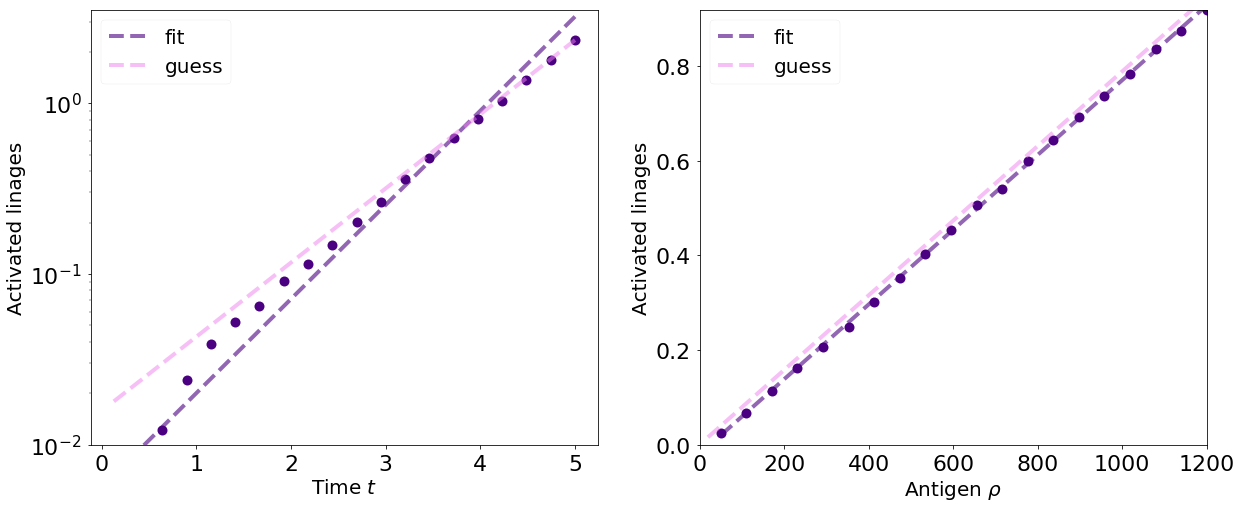

In [276]:
fig, ax = plt.subplots(1,2,figsize=(20,8))
gamma = 1
R_0 = 12
b = 100*np.exp(-14+1.5+3/4)
print()
#________________________________________________________________________________________

t_new = np.linspace(0, 5, 40)
activation_time_series_t = pickle.load( open( "../Text_files/activation_time_series_t.pkl", "rb" ) )
popt, pcov = curve_fit(linear_func, t_new[1:], np.log10(activation_time_series_t[1:]))
ax[0].plot(t_new[1:][::2], activation_time_series_t[1:][::2], '.', ms = 20, linewidth = 4, color = 'indigo')
ax[0].plot(t_new[1:], 10**linear_func(t_new[1:], *popt), '--', ms = 20, linewidth = 4, color = 'indigo', alpha = 0.6, label = 'fit')
activation_time_series_i = [np.sum(Model.activation_time_series[:,i]) for i in range(int(len(Model.activation_time_series[0,:])))]
ax[0].plot(t_new[1:], 20*b*np.exp(t_new[1:]), '--', color = 'violet', alpha = 0.5, linewidth = 4, label ='guess')
#ax[0].plot(Model.time_series, activation_time_series_i, color = 'indigo', alpha = 0.3)
print(*popt)
ax[0].set_xlabel(r'Time $t$', fontsize = 20)
ax[0].set_ylabel(r'Activated linages', fontsize = 20)
ax[0].tick_params(labelsize = 22)
#ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_ylim(0.01, max(activation_time_series_t[1:]*1.5))
ax[0].legend(loc = 0, fontsize = 20)

#________________________________________________________________________________________

rho_new = np.linspace(20, max_rho, 40)
activation_time_series_rho = pickle.load( open( "../Text_files/activation_time_series_rho.pkl", "rb" ) )
activation_time_series_rho_var = pickle.load( open( "../Text_files/activation_time_series_rho_var.pkl", "rb" ) )

popt, pcov = curve_fit(linear_func, rho_new[1:], activation_time_series_rho[1:])

ax[1].plot(rho_new[1:][::2], activation_time_series_rho[1:][::2], '.', ms = 20, linewidth = 4, color = 'indigo')
ax[1].plot(rho_new[1:], linear_func(rho_new[1:], *popt), '--', ms = 20, linewidth = 4, color = 'indigo', alpha = 0.6, label ='fit')
#ax[1].plot(Model.antigen_time_series, activation_time_series_i, color = 'violet', alpha = 0.3)
#ax[1].plot(rho_new, linear_func(rho_new, 0, np.exp(5-14)*6.6 ), '--', color = 'violet', alpha = 0.5, linewidth = 4, label ='guess')
ax[1].plot(rho_new, linear_func(rho_new, 0, b), '--', color = 'violet', alpha = 0.5, linewidth = 4, label ='guess')

print(*popt)
#ax[1].fill_between(rho_new, activation_time_series_rho-np.sqrt(activation_time_series_rho_var), activation_time_series_rho + np.sqrt(activation_time_series_rho_var), color='indigo', alpha = 0.3)
#ax[1].plot(rho_new, (1/gamma)*(rho_new*np.exp(-12-(-5))-1))
#ax[1].plot(rho_new, 4.4*(rho_new*np.exp(-12-(-5.5))))
ax[1].set_xlabel(r'Antigen $\rho$', fontsize = 20)
ax[1].set_ylabel(r'Activated linages', fontsize = 20)
ax[1].tick_params(labelsize = 22)
#ax[1].set_xscale('log')
#ax[1].set_yscale('log')
ax[1].set_xlim(0,max_rho)
ax[1].set_ylim(0,np.max(activation_time_series_rho[1:]))
ax[1].legend(loc = 0, fontsize = 20)

#________________________________________________________________________________________

counter = 0
while(os.path.isfile('../Figures/Activation_rate_%d.png'%(counter))):
    counter+=1
    
#fig.savefig('../Figures/Activation_rate_%d.png'%(counter))
#plt.close()
print(np.exp(5-14)*7)

(1, 200000.0)

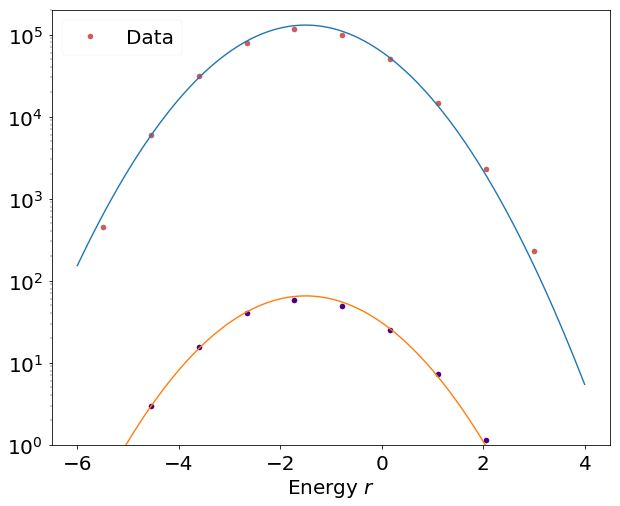

In [309]:
fig, ax = plt.subplots(1,1, figsize = (10, 8))
#___________________________________________
energies = plot_histogram_energy(Sequences = Sequences, bins = 10, ax = ax)
r_array = np.linspace(np.min(energies), np.min(energies)+5, 100)
r_array_2 = np.linspace(-6, 4, 100)
sigma = 3
ax.plot(r_array_2, (4e5/(np.sqrt(np.pi*sigma)))*np.exp(-(1/sigma)*(r_array_2+1.5)**2))
#ax.plot(r_array, 1*np.exp(7*(r_array+5.5)))
#___________________________________________
#sub_energies = np.array([])
#for i in range(5000):
#   Sub_Sequences = np.random.choice(Sequences, n_linages)
#    sub_energies = np.append(sub_energies,np.array([i.energy for i in Sub_Sequences]))
data_energies = np.histogram(sub_energies, bins=10)
ax.plot(data_energies[1][0:-1], data_energies[0]/(5000), linewidth = 4, color = 'indigo', label = 'Data', linestyle = '', marker = 'o')
#ax.plot(r_array, np.exp(1*(r_array+4)))
ax.plot(r_array_2, (200/(np.sqrt(np.pi*sigma)))*np.exp(-(1/sigma)*(r_array_2+1.5)**2))
#___________________________________________   
#ax.set_xlim(np.min(energies)-0.1, np.min(energies)+2)
#ax.set_yscale('linear')
ax.set_ylim(1, 2e5)

## Detection time

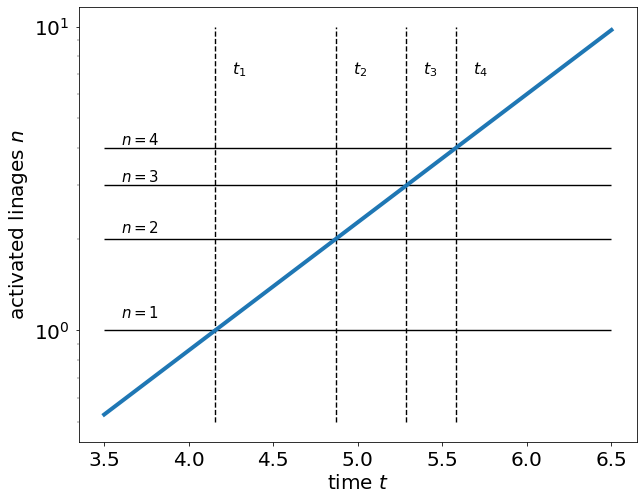

In [185]:
fig, ax = plt.subplots(1,1, figsize=(10,8))

t = np.linspace(3.5, 6.5, 50)
N_b = 10**(-1.7530906647767526)*10**(0.4218331847047946*t)

ax.plot(t, N_b, linewidth = 4)

ax.hlines([1, 2, 3, 4], 3.5, 6.5)
ax.vlines(np.log10(np.array([1,2,3,4])/(10**(-1.7530906647767526)))/(0.4218331847047946), .5, 10, linestyle = 'dashed')

ax.text(3.6,1.1, r'$n = 1$', fontsize = 15)
ax.text(3.6,2.1, r'$n = 2$', fontsize = 15)
ax.text(3.6,3.1, r'$n = 3$', fontsize = 15)
ax.text(3.6,4.1, r'$n = 4$', fontsize = 15)

ax.text(np.log10(np.array([1])/(10**(-1.7530906647767526)))/(0.4218331847047946) + .1 ,7, r'$t_1$', fontsize = 16)
ax.text(np.log10(np.array([2])/(10**(-1.7530906647767526)))/(0.4218331847047946) + .1 ,7, r'$t_2$', fontsize = 16)
ax.text(np.log10(np.array([3])/(10**(-1.7530906647767526)))/(0.4218331847047946) + .1 ,7, r'$t_3$', fontsize = 16)
ax.text(np.log10(np.array([4])/(10**(-1.7530906647767526)))/(0.4218331847047946) + .1 ,7, r'$t_4$', fontsize = 16)

#ax.text(0, 20, r'$t_n \approx \ln{\left(\frac{n}{UR}\right)} + R_0$', fontsize = 25)
ax.set_xlabel(r'time $t$', fontsize = 20)
ax.set_ylabel(r'activated linages $n$', fontsize = 20)
ax.set_yscale('log')
ax.tick_params(labelsize = 20)
#ax.legend(fontsize = 20)
fig.savefig('../Figures/Activation_times.png')


In [8]:
Sequences2 = pickle.load( open( "../Text_files/Sequences-n_seq-%d.pkl"%(100), "rb" ) )

fig, ax = plt.subplots(1,3,figsize=(30,8))

distances = plot_histogram_hamming_distance(Sequences = Sequences2, ax = ax[0])
energies = plot_histogram_energy(Sequences = Sequences2, bins = 100, ax = ax[1])
plot_scatter_hamming_distance_energy(distances = distances, energies = energies, ax = ax[2])

fig.savefig('../Figures/Sequences-n_seq-%d.png'%(100))
plt.close()


In [46]:
1/(1+np.exp(Sequences[200000].energy+3)), Sequences[200000].hamming_distance

(0.3143198860617463, 6)